# Biologia Systemów - Spektroskopia Mas i Spektroskopia NMR

In [1]:
!pip install gdown
!pip install plotly
!pip install git+https://github.com/BDomzal/magnetstein.git
!pip install gurobipy>=10
!pip install pulp

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/BDomzal/magnetstein.git to /tmp/pip-req-build-f2w7lcd8
  Running command git clone --filter=blob:none --quiet https://github.com/BDomzal/magnetstein.git /tmp/pip-req-build-f2w7lcd8
  Resolved https://github.com/BDomzal/magnetstein.git to commit 547d8b1a262f5967b0b40453fcb60f9ee068749b
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import gdown

# Link do pliku z Google Drive
file_id = '1vKE5-29ZgBK_yew1dr5Ne7JLULxSdRZi'
url = f'https://drive.google.com/uc?id={file_id}'

# Ścieżka do zapisu
output = 'Data_urine.zip'

# Pobieranie
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1vKE5-29ZgBK_yew1dr5Ne7JLULxSdRZi
To: /home/marysia/Documents/Biologia systemów/NMR/Data_urine.zip
100%|██████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 19.3MB/s]


'Data_urine.zip'

In [4]:
import zipfile

with zipfile.ZipFile('Data_urine.zip', 'r') as zip_ref:
    zip_ref.extractall('Data_urine')

In [9]:
DATA_PATH = 'Data_urine'

## Zadanie 1 - ekstrakcja plików i preprocessing

#### Funkcja extract_1D_spectra(folder_path:str, nucleus:str) przechodzi po wszystkich plikach w folderze ze spektrami z bazy HMDB dla danego jądra i towrzy nowy plik, który zawiera wszsytkie chemical_shift, peak_position oraz intensity znalezione w plikach

In [2]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import csv
import re

In [3]:
def extract_1D_spectra(folder_path: str, nucleus: str):
    parent_dir = os.path.dirname(folder_path.rstrip(os.sep))
    output_folder = os.path.join(parent_dir, 'extracted_spectra')
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            filepath = os.path.join(folder_path, filename)
            stripped = filename.strip().split('_')
            if stripped[2] == 'one':
                tree = ET.parse(filepath)
                root = tree.getroot()

                spectrum_nucleus = root.findtext('nucleus')
                if spectrum_nucleus != nucleus:
                    continue

                # Pobranie informacji ogólnych
                hmdb_id = root.findtext('database-id')
                spectrum_id = root.findtext('id')
                frequency = root.findtext('frequency') or ""
                frequency = re.sub(r'\s*[mM][hH][zZ]\s*', '', frequency).strip()
                predicted = root.findtext('predicted') == 'true'
                pred_or_exper = 'predicted' if predicted else 'experimental'
                output_filename = f"{hmdb_id}_1D_{spectrum_id}_{pred_or_exper}_{nucleus}_{frequency}.csv"
                output_filepath = os.path.join(output_folder, output_filename)


                peaks = root.findall('.//nmr-one-d-peak')

                # Zapis danych do CSV
                with open(output_filepath, mode='w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(['chemical_shift', 'peak_position_ppm', 'intensity'])

                    for peak in peaks:
                        chemical_shift = peak.findtext('chemical-shift')
                        peak_position = peak.findtext('peak-position-ppm')
                        intensity = peak.findtext('intensity')

                        if chemical_shift and peak_position and intensity:
                            writer.writerow([chemical_shift, peak_position, intensity])

In [33]:
extract_1D_spectra('hmdb_nmr_spectra', '1H')

#### Funkcja preprocess_1D_spectra(filename: str, out_folder:str, sig:int) wczytuje plik w formacie stworzonym przez funkcję extract_1D_spectra i grupuje piki po ich pozycji i przypisuje im nową intensywność równą sumie intensywności, zaokrąla (opcjonalnie) pozycje pików do sig liczb znaczących. Następnie zapisuje plik w folderze out_folder z końcówką _processed

In [4]:
import numpy as np

def preprocess_1D_spectra(filename: str, out_folder="./Preprocessed", sig=None):
    df = pd.read_csv(filename)

    if sig is not None:
        def round_sig(x, sig):
            return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0
        df["peak_position_ppm"] = df["peak_position_ppm"].apply(lambda x: round_sig(x, sig))

    grouped = df.groupby("peak_position_ppm", as_index=False).agg({"intensity": "sum"})
    grouped["chemical_shift"] = grouped["peak_position_ppm"]

    final_df = grouped[["chemical_shift", "peak_position_ppm", "intensity"]]

    os.makedirs(out_folder, exist_ok=True)
    out_filename = os.path.basename(filename).replace(".csv", "_processed.csv")
    final_df.to_csv(os.path.join(out_folder, out_filename), index=False)


In [35]:
for file in os.listdir('extracted_spectra'):
    preprocess_1D_spectra(f"extracted_spectra/{file}")

##### Pliki z metabolitami wykrytymi w moczu oraz skwantyfikowanymi znajdują się w folderze "metabolites" repozytorium, uzyskane zostały przez pobranie wyników wyszukiwania w bazie HMDB

In [5]:
import pandas as pd

df = pd.read_csv("detected")

df.head()

,HMDB_ID,NAME,SMILES,INCHIKEY,CHEMICAL_FORMULA,AVERAGE_MASS,MONO_MASS
0,HMDB0000001,1-Methylhistidine,CN1C=NC(C[C@H](N)C(O)=O)=C1,BRMWTNUJHUMWMS-LURJTMIESA-N,C7H11N3O2,169.1811,169.085127
1,HMDB0000002,"1,3-Diaminopropane",NCCCN,XFNJVJPLKCPIBV-UHFFFAOYSA-N,C3H10N2,74.1249,74.084398
2,HMDB0000005,2-Ketobutyric acid,CCC(=O)C(O)=O,TYEYBOSBBBHJIV-UHFFFAOYSA-N,C4H6O3,102.0886,102.031694
3,HMDB0000008,2-Hydroxybutyric acid,[H]OC(=O)[C@@]([H])(O[H])C([H])([H])C([H])([H]...,AFENDNXGAFYKQO-VKHMYHEASA-N,C4H8O3,104.1050,104.047344
4,HMDB0000010,2-Methoxyestrone,[H][C@@]12CCC(=O)[C@@]1(C)CC[C@]1([H])C3=C(CC[...,WHEUWNKSCXYKBU-QPWUGHHJSA-N,C19H24O3,300.3921,300.172545


#### Funkcja count_experimental_1D_1H(hmdb_csv_path:str, pocessed_spectra_folder: str) sprawdza jak wiele metabolitów wykrytych w moczu, skwantyfikowanych i nieskwantyfikowanych posiada widmo eksperymentalne w bazie HMDB.  
Przechodzi po plikach wynikowych funkcji  __preprocess_1D_spectra__ i na podstawie nazwy pliku sprawdza, czy dany metabolit znajduje się na liście szukanych metabolitów oraz czy widmo jest eksperymentalne.

In [6]:
def count_experimental_1D_1H(hmdb_csv_path: str, processed_spectra_folder: str):
    df = pd.read_csv(hmdb_csv_path)
    hmdb_ids = set(df.iloc[:, 0].astype(str))

    matched_ids = set()

    for filename in os.listdir(processed_spectra_folder):
        stripped = filename.strip().split('_')
        if stripped[3] == 'experimental' and stripped[0] in hmdb_ids:
            matched_ids.add(stripped[0])

    print(f"Liczba dopasowanych metabolitów ({hmdb_csv_path}): {len(matched_ids)}")

In [7]:
count_experimental_1D_1H("detected","Preprocessed")
count_experimental_1D_1H("detected_quantified","Preprocessed")
count_experimental_1D_1H("detected_notquantified","Preprocessed")

Liczba dopasowanych metabolitów (detected): 772
Liczba dopasowanych metabolitów (detected_quantified): 649
Liczba dopasowanych metabolitów (detected_notquantified): 123


In [10]:
selected = pd.read_csv(f'{DATA_PATH}/selected_metabolites.csv')

In [11]:
selected.head()

,ppm shift,name,HMDB.ca ID
0,1.0680,S-3-hydroxyisobutyrate,HMDB0000023
1,1.1127,4-deoxythreonic acid,HMDB0002453
2,1.2390,4-deoxyerythreonic acid,HMDB0000498
3,1.2740,3-hydroxyisovalerate,HMDB0000754
4,1.3397,lactic acid,HMDB0000190


#### Funkcja count_selected_metabolites(selected_path: str, processed_spectra_folder: str) sprawdza jak dużo metabolitów spośród wybranych posiada widmo eksperymentalne oraz jakiej intensywności, przyda się to podczas wybierania widm do biblioteki referencyjnej.  
Działa podobnie do funkcji count_experimental_1D_1H, zwraca słownik gdzie kluczem jest id z bazy HMDB danego metabolitu a wartościami są pary [intensywność, spektrum id].

In [12]:
import re
def count_selected_metabolites(selected_path: str, processed_spectra_folder: str):
    selected = pd.read_csv(f'{DATA_PATH}/{selected_path}')
    hmdb_ids = set(selected.iloc[:,2].astype(str))
    matched_ids = {}
    for filename in os.listdir(processed_spectra_folder):
        stripped = re.split(r'[.,_]+', filename)
        # stripped [5] != 'processed' - zabezpieczenie, czasem nie ma podanej intensywności. 
        if stripped[3] == 'experimental' and stripped[0] in hmdb_ids and stripped[0] not in matched_ids and stripped[5] != 'processed':
            matched_ids[stripped[0]] = [[int(stripped[5]), int(stripped[2])]]
        elif stripped[3] == 'experimental' and stripped[0] in hmdb_ids and stripped[0] in matched_ids and stripped[5] != 'processed':
            matched_ids[stripped[0]].append([int(stripped[5]), int(stripped[2])])
    return matched_ids
    

In [13]:
experimental = count_selected_metabolites('selected_metabolites.csv', 'Preprocessed')
print(experimental)
print(len(experimental))

{'HMDB0000754': [[600, 166676], [600, 166332], [600, 1523]], 'HMDB0000956': [[600, 1621]], 'HMDB0000042': [[500, 166397], [700, 166406], [90, 2560], [500, 166395], [500, 166402], [500, 1048], [500, 166401], [500, 166322], [700, 166320], [500, 166398], [500, 166399], [500, 166403], [500, 166405], [500, 166400], [500, 166321], [500, 166396], [500, 166404], [500, 166638]], 'HMDB0001870': [[90, 2566], [600, 1769]], 'HMDB0000714': [[600, 1494], [90, 2398]], 'HMDB0000142': [[500, 1107], [400, 3951]], 'HMDB0011635': [[500, 2052], [500, 166649], [500, 166410], [500, 166329], [500, 166409], [500, 166324], [500, 166650], [500, 166420]], 'HMDB0000812': [[500, 1553]], 'HMDB0000682': [[600, 1475]], 'HMDB0000925': [[300, 2177], [500, 1605]], 'HMDB0000094': [[500, 1080], [400, 2634]], 'HMDB0000161': [[500, 1120]], 'HMDB0000767': [[500, 1533]], 'HMDB0000087': [[500, 1077]], 'HMDB0000023': [[500, 1037]], 'HMDB0000875': [[600, 1579], [400, 3898]], 'HMDB0000211': [[600, 166630], [600, 1200]], 'HMDB000056

#### Funkcja choose_spectra(selected_metabolites: str, peocessed_spectra_folder: str) wybiera spektra tworzące bibliotekę referencyjną, kryterium wyboru jest następujące: wybierz niepuste widmo o największej częstotliwości. Jeśli metabolit posiada widmo eksperymentalne wybieraj ze zbioru widm eksperymentalnych dla tego metabolitu, jeśli nie wybieraz ze zbioru widm przewidywanych.  
Funkcja zwraca słownik gdzie kluczem jest nazwa metabolitu a wartością jest nazwa pliku z wybranym widmem

In [14]:
import warnings
def choose_spectra(selected_metabolites: str, processed_spectra_folder: str):
    max_freq_exper = {}
    chosen = {}
    selected = pd.read_csv(f'{DATA_PATH}/{selected_metabolites}')
    id_to_name = dict(zip(selected.iloc[:, 2].astype(str), selected.iloc[:, 1].astype(str)))
    hmdb_ids = set(id_to_name.keys())
    experimental = count_selected_metabolites(selected_metabolites, processed_spectra_folder)
    for key, value in experimental.items():
        for pair in sorted(value, key=lambda x: x[0], reverse=True):
            freq, spec_id = pair
            filename = f"{key}_1D_{spec_id}_experimental_1H_{freq}_processed.csv"
            path = os.path.join(processed_spectra_folder, filename)
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("error") 
                    data = np.loadtxt(path, delimiter=',', skiprows=1)
                if data.size == 0:
                    continue
                max_freq_exper[key] = (freq, spec_id)
                break
            except Exception as e:
                continue
    for hmdb_id in hmdb_ids:
        metabolite_name = id_to_name[hmdb_id]
        if hmdb_id in max_freq_exper:
            freq, sid = max_freq_exper[hmdb_id]
            filename = f"{hmdb_id}_1D_{sid}_experimental_1H_{freq}_processed.csv"
        else:
            max_freq = 0
            max_freq_id = 0
            filename = None
            for fname in os.listdir(processed_spectra_folder):
                stripped = re.split(r'[.,_]+', fname)
                if stripped[0] == hmdb_id and "predicted" in fname:
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("error")
                            data = np.loadtxt(os.path.join(processed_spectra_folder, fname), delimiter=',', skiprows=1)
                        if data.size == 0:
                            continue
                    except Exception:
                        continue
                    freq = int(stripped[5])
                    if freq > max_freq:
                         max_freq = freq
                         max_freq_id = int(stripped[2])
                         filename = fname
            if not filename:
                continue  # nic nie znaleziono
        chosen[metabolite_name] = filename
    return chosen
        

In [15]:
selected_spectra = choose_spectra('selected_metabolites.csv', 'Preprocessed')
print(selected_spectra)
print(len(selected_spectra))

{'lactic acid': 'HMDB0000190_1D_1162_experimental_1H_500_processed.csv', 'alanine': 'HMDB0000161_1D_1120_experimental_1H_500_processed.csv', '2-hydroxyisobutyrate': 'HMDB0242161_1D_91235_predicted_1H_1000_processed.csv', 'citric acid': 'HMDB0000094_1D_1080_experimental_1H_500_processed.csv', 'benzoic acid': 'HMDB0001870_1D_1769_experimental_1H_600_processed.csv', 'N-acetyl-aspartic acid': 'HMDB0000812_1D_1553_experimental_1H_500_processed.csv', 'S-3-hydroxyisobutyrate': 'HMDB0000023_1D_1037_experimental_1H_500_processed.csv', '4-hydroxyphenylacetate': 'HMDB0060390_1D_57854_predicted_1H_1000_processed.csv', 'dimethylamine': 'HMDB0000087_1D_1077_experimental_1H_500_processed.csv', '4-hydroxyhippuric acid': 'HMDB0013678_1D_12041_predicted_1H_1000_processed.csv', 'succinic acid': 'HMDB0000254_1D_1285_experimental_1H_500_processed.csv', 'N1-methyl-pyridone-5-carboxamide': 'HMDB0004193_1D_41824_predicted_1H_1000_processed.csv', '3-hydroxyisovalerate': 'HMDB0000754_1D_1523_experimental_1H_600

## Zadanie 2 - wykresy widm i estymacja proporcji

In [16]:
import pandas as pd
import numpy as np
import masserstein
from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions
import matplotlib.pyplot as plt

Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


#### Funkcja plot_spectra_model_experimental(selected_spectra: dict, experimental_sample: str) za pomocą słownika otrzymanego w poprzedniej funkcji oraz ścieżki do pliku z próbką pochodzącą z eksperymentu tworzy wykresy spektrum oraz zwraca listę spektrum jako obiektów biblioteki masserstein.  
Każde spektrum zostaje znormalizowane oraz usuwane są intensywności poniżej 0.

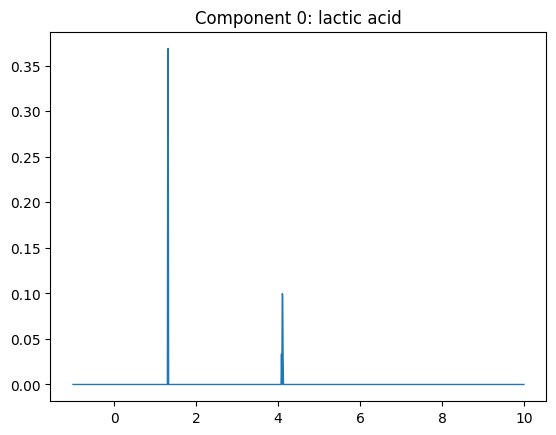

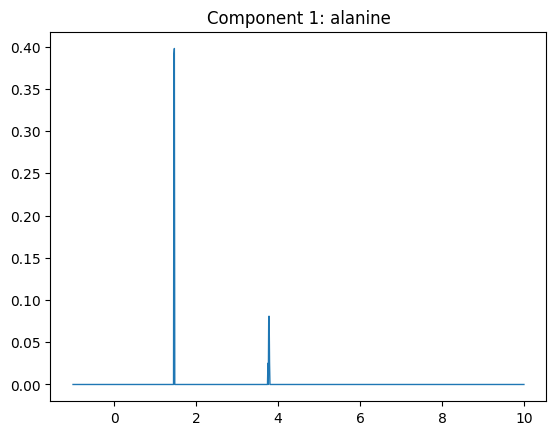

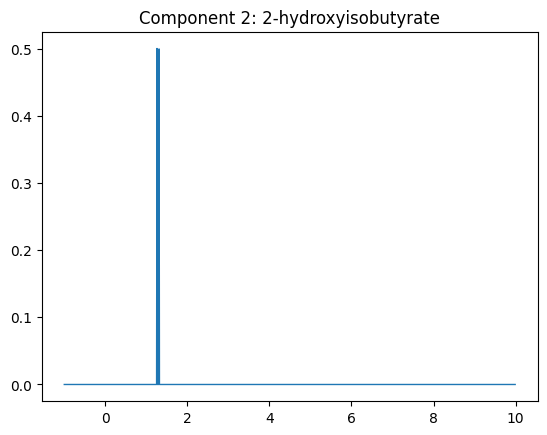

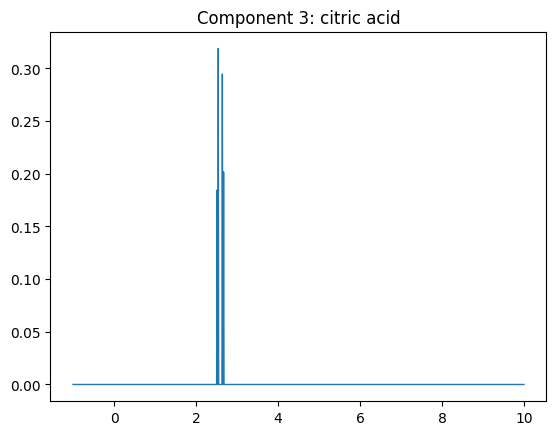

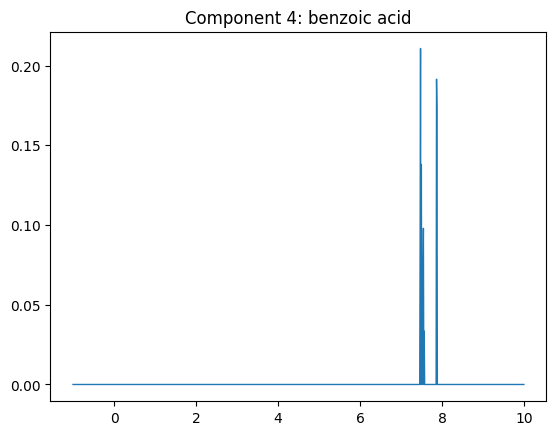

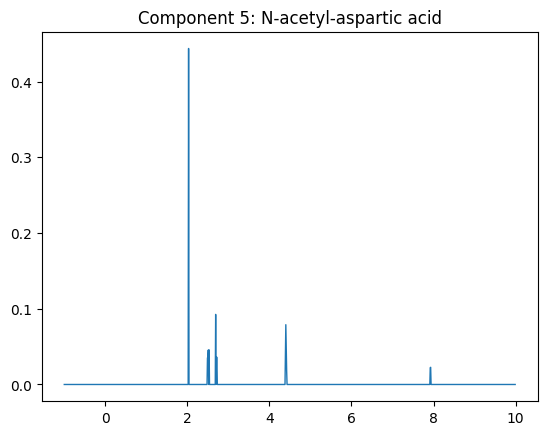

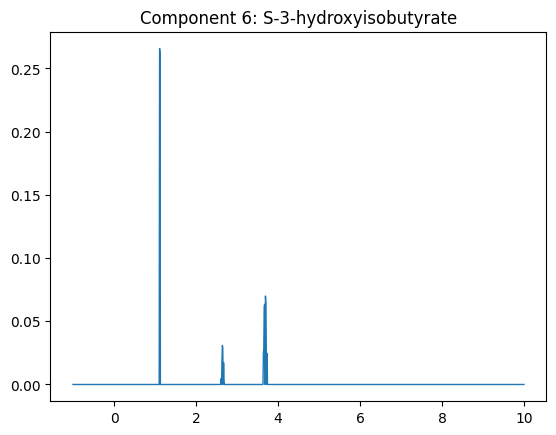

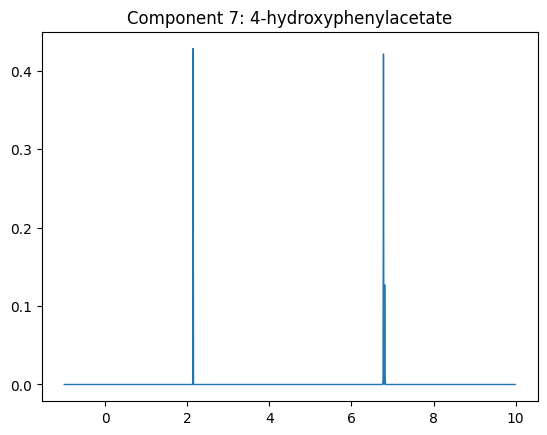

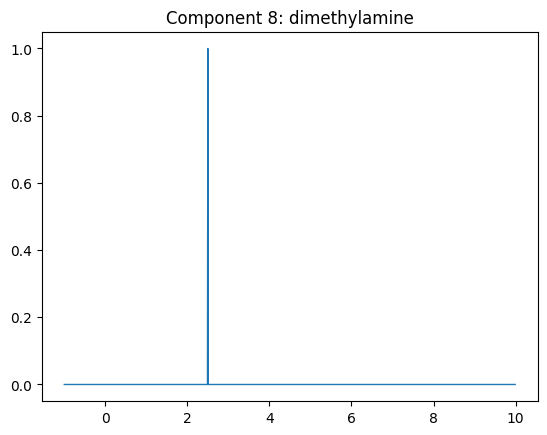

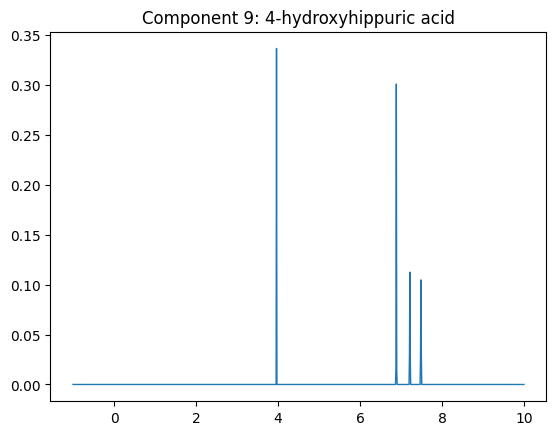

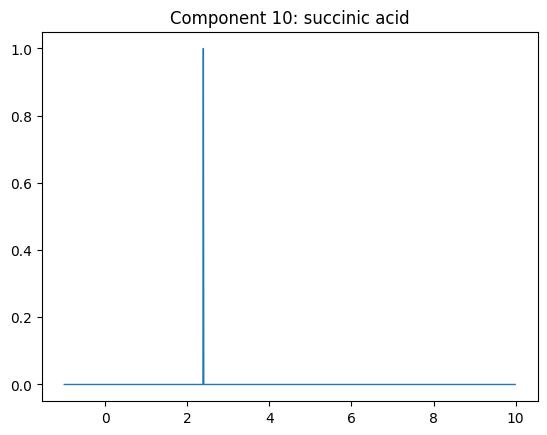

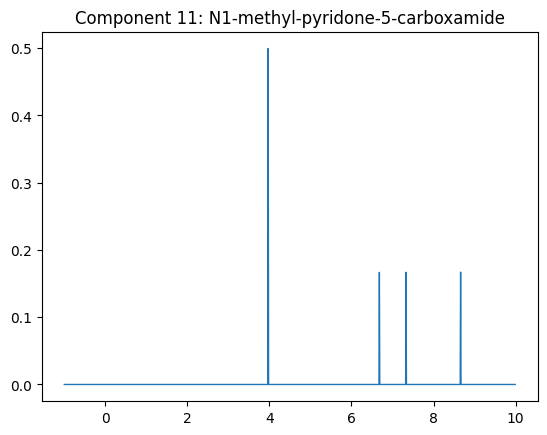

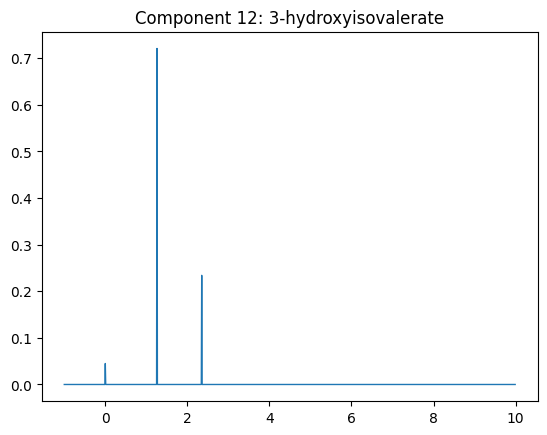

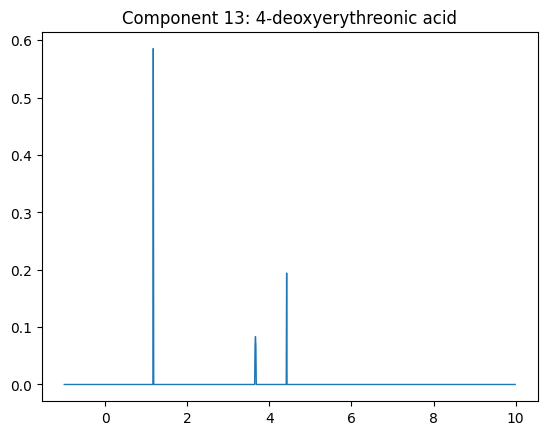

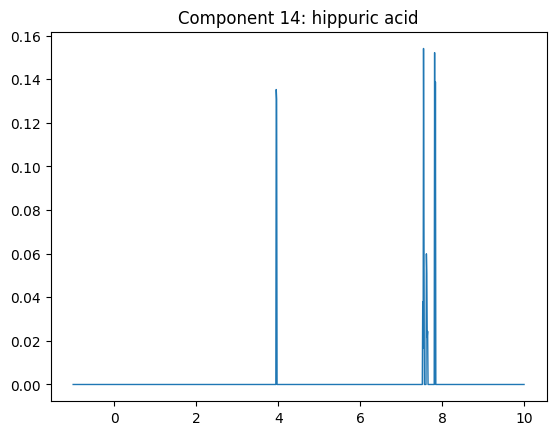

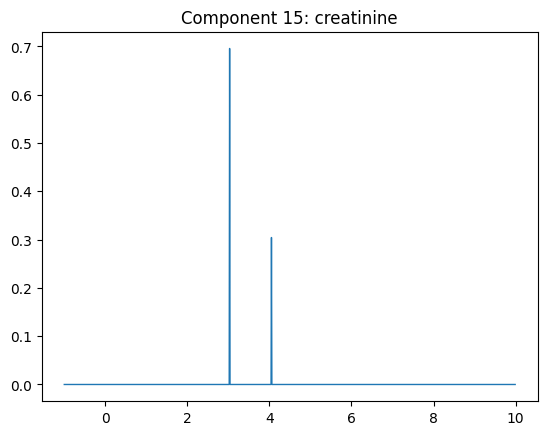

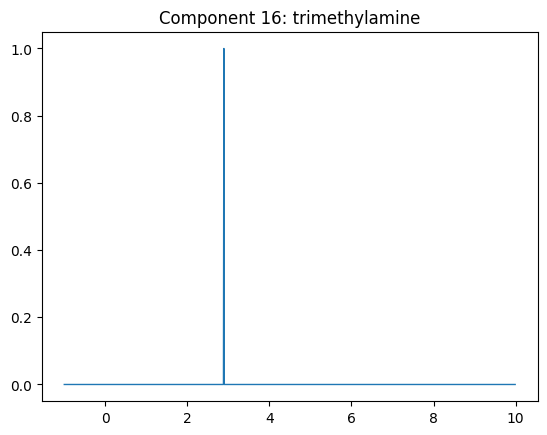

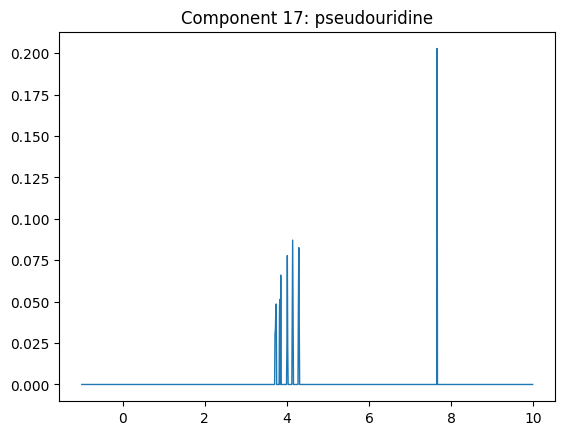

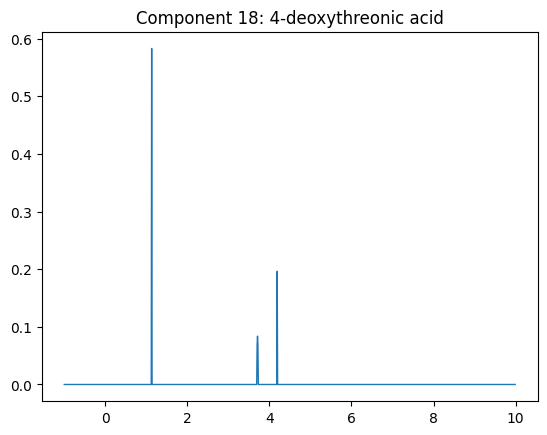

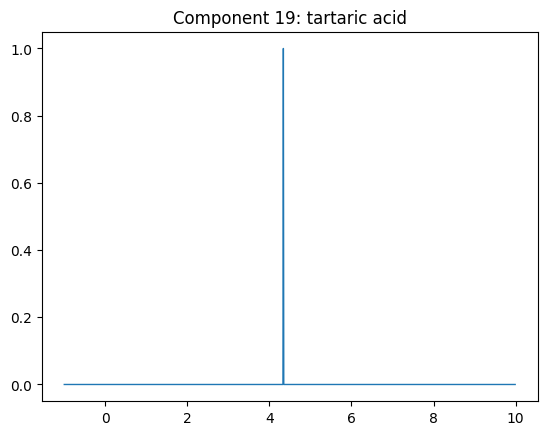

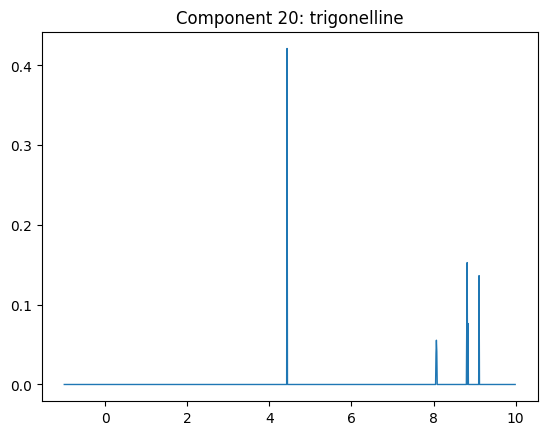

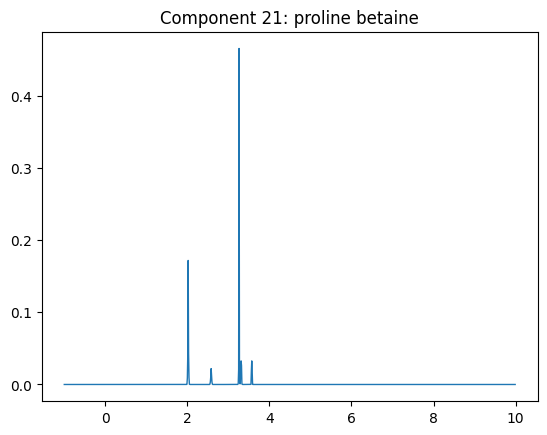

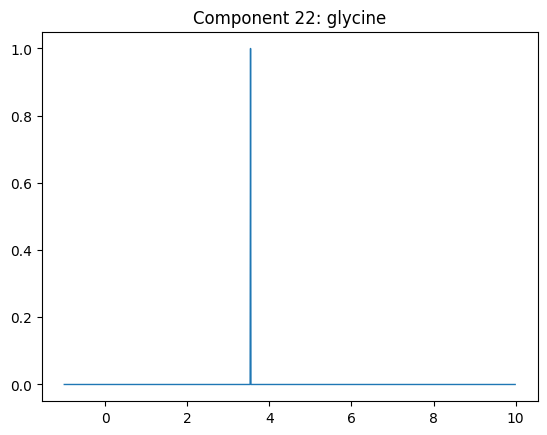

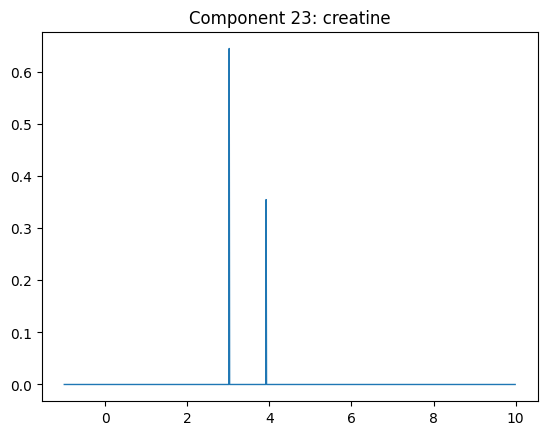

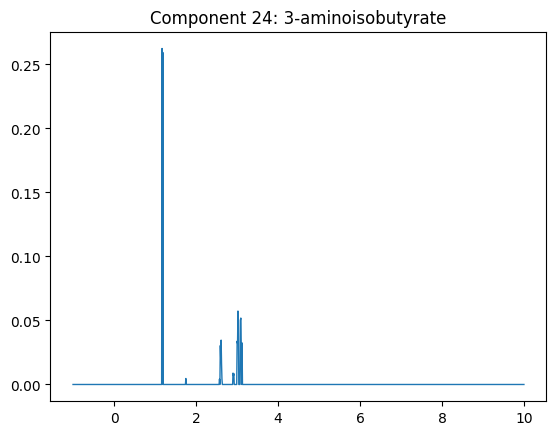

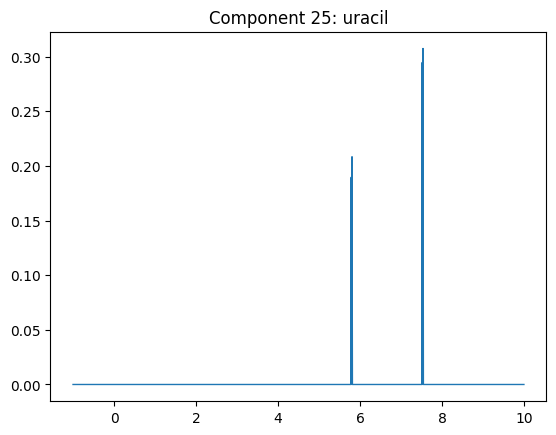

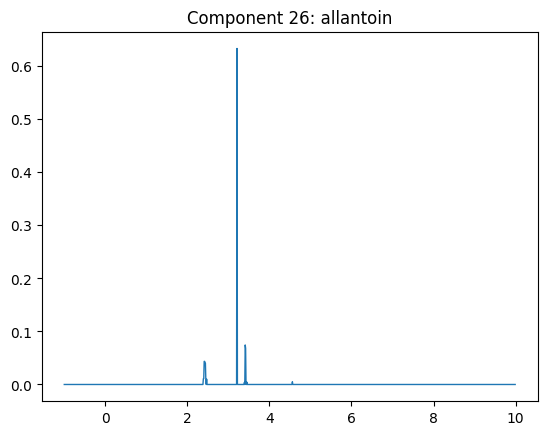

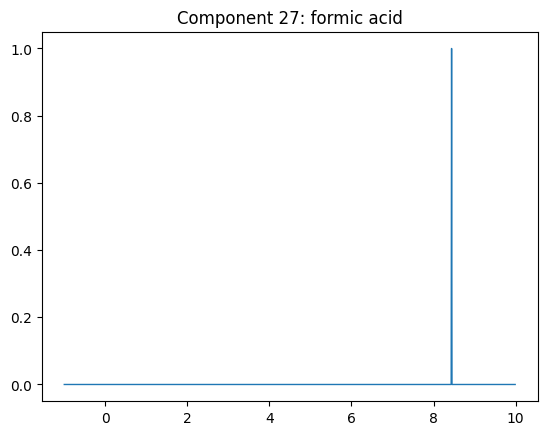

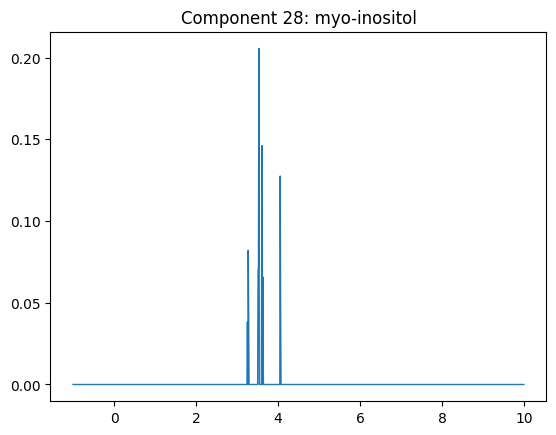

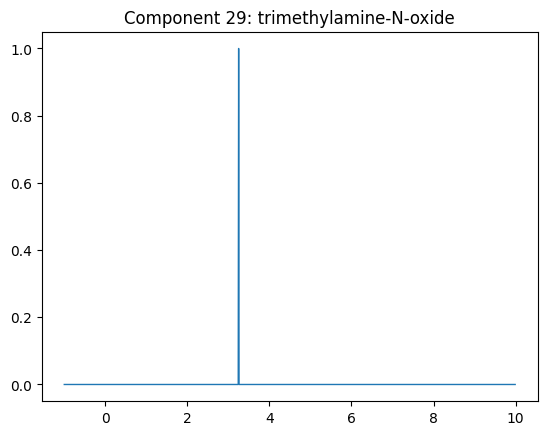

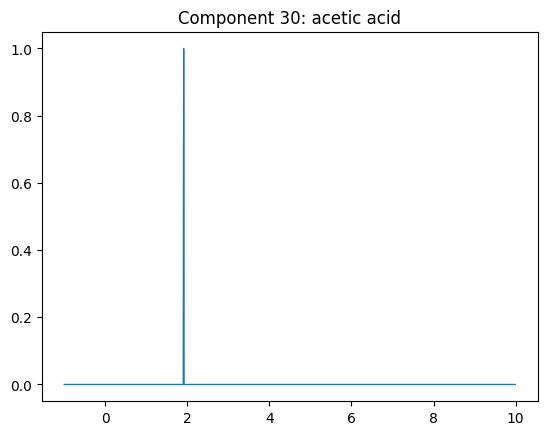

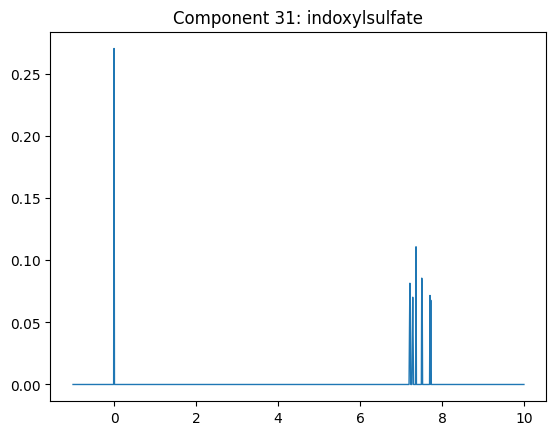

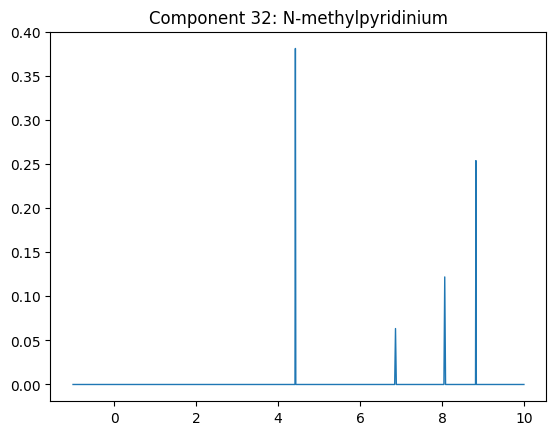

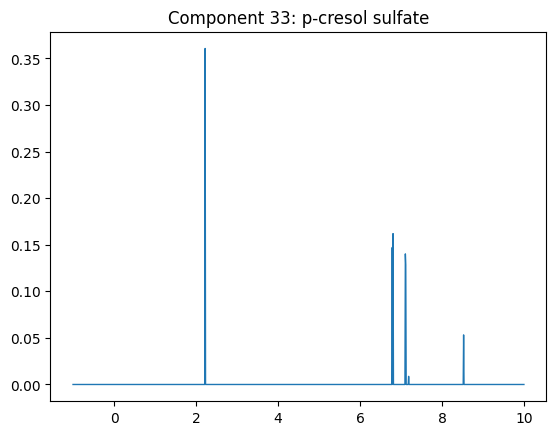

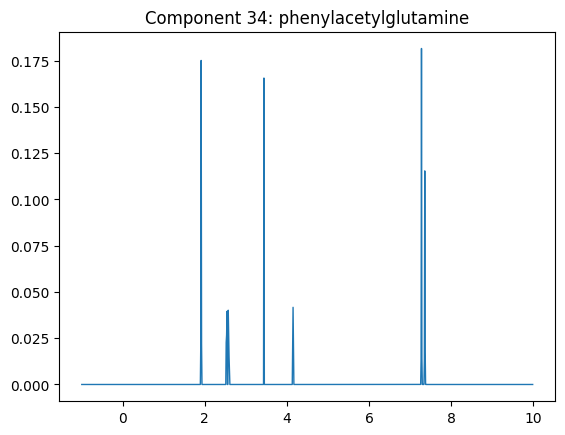

[[-7.50250000e-01 -3.35504740e+02]
 [-7.50000000e-01 -4.09193439e+02]
 [-7.49750000e-01 -7.53964540e+02]
 ...
 [ 9.74950000e+00  6.05780502e+02]
 [ 9.74975000e+00  5.56642056e+02]
 [ 9.75000000e+00  5.59276434e+02]]


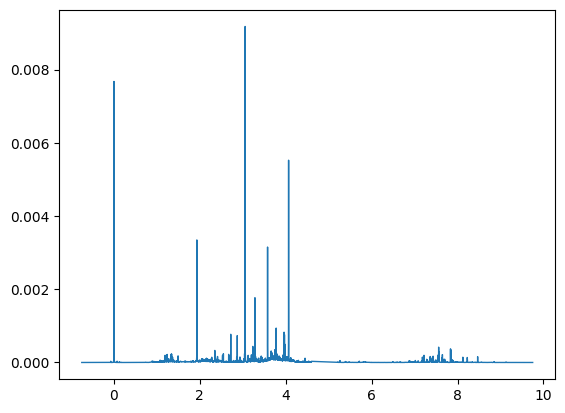

In [19]:
def plot_spectra_model_experimental(selected_spectra: dict, experimental_sample: str):
    spectra = []    
    
    for name, file in selected_spectra.items():
        table = np.loadtxt(f'Preprocessed/{file}', delimiter = ',', skiprows = 1)
        if table.ndim == 1:
           table = table[np.newaxis, :]
        chemical_shifts = table[:,1]
        intensities = table[:,2]
        ppm_grid = np.arange(-1, 10, 0.01)
        spectrum = np.zeros_like(ppm_grid)
        
        for shift, intensity in zip(chemical_shifts, intensities):
            idx = np.argmin(np.abs(ppm_grid - shift))
            spectrum[idx] += intensity
        nmr_spectrum = NMRSpectrum(confs = list(zip(ppm_grid, spectrum)), label = name)
        nmr_spectrum.normalize()
        nmr_spectrum.trim_negative_intensities()
        spectra.append(nmr_spectrum)
    
    for i, s in enumerate(spectra):
        plt.title(f'Component {i}: {s.label}')
        s.plot(profile=True)
    
    exp = np.loadtxt(f'{DATA_PATH}/Urine_samples/{experimental_sample}', delimiter=',')
    print(exp)
    exp = NMRSpectrum(confs=list(zip(exp[:,0], exp[:,1])), label=experimental_sample) 
    print(exp)
    exp.trim_negative_intensities()
    exp.normalize()
    exp.plot(profile=True)
    
    return spectra
    
        

spectra = plot_spectra_model_experimental(selected_spectra,  '1_V5001_D1.csv')

In [20]:
import gurobipy as gp
import pulp as pl
print(gp.gurobi.version())

(12, 0, 2)


### Estymacja parametrów

Aby użyć solvera GUROBI należy uzupełnić dane swojej licencji

In [42]:
params = {
"WLSACCESSID": '8',
"WLSSECRET": '',
"LICENSEID":,
}
env = gp.Env(params=params)

SyntaxError: expression expected after dictionary key and ':' (2896727808.py, line 4)

In [22]:
solver = pl.apis.LpSolverDefault
pl.listSolvers(onlyAvailable = True)

['GLPK_CMD', 'GUROBI', 'PULP_CBC_CMD', 'HiGHS', 'HiGHS_CMD']

In [23]:
from masserstein import estimate_proportions

In [24]:
kappa_mixture = 0.27
kappa_components = 0.26
exp = np.loadtxt(f'{DATA_PATH}/Urine_samples/1_V5001_D1.csv', delimiter=',')
exp = NMRSpectrum(confs=list(zip(exp[:,0], exp[:,1])), label='255_V5001_D716.csv') 
exp.trim_negative_intensities()
exp.normalize()

estimation_result = estimate_proportions(spectrum = exp,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                        #  solver = pl.apis.LpSolverDefault,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area', # default
                                         )

Component's spectrum 7 is not normalized.
Normalizing component's spectrum 7.
Component's spectrum 21 is not normalized.
Normalizing component's spectrum 21.
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.0, 9.990000000000009, 0), (-1.0, 9.990000000000009, 1), (-1.0, 9.990000000000009, 2), (-1.0, 9.990000000000009, 3), (-1.0, 9.990000000000009, 4), (-1.0, 9.990000000000009, 5), (-1.0, 9.990000000000009, 6), (-1.0, 9.990000000000009, 7), (-1.0, 9.990000000000009, 8), (-1.0, 9.990000000000009, 9), (-1.0, 9.990000000000009, 10), (-1.0, 9.990000000000009, 11), (-1.0, 9.990000000000009, 12), (-1.0, 9.990000000000009, 13), (-1.0, 9.990000000000009, 14), (-1.0, 9.990000000000009, 15), (-1.0, 9.990000000000009, 16), (-1.0, 9.990000000000009, 17), (-1.0, 9.990000000000009, 18), (-1.0, 9.990000000000009, 19), (-1.0, 9.990000000000009, 20), (-1.0, 9.990000000000009, 21), (-1.0, 9.990000000000009, 22), (-1.0, 9.990000000000009, 23), (-1.0, 9.99

/home/marysia/.local/lib/python3.10/site-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.52349271
Noise proportion in mixture's spectrum: 0.4765072904260026
Total explanation: 1.0000000004260026
Noise proportion in combination of components' spectra: 0.18795558


In [25]:
estimation_result

{'proportions': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.5234927100000037],
 'noise': [-0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  1.8961000000000136e-08,
  3.6642000000000256e-08,
  5.773600000000041e-08,
  2.8886000000000207e-08,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  5.326000000000038e-09,
  -0.0,
  -0.0,
  -0.0,
  3.842400000000027e-08,
  8.758800000000063e-08,
  7.819900000000055e-08,
  2.0378000000000144e-08,
  2.8348000000000202e-08,
  7.16490000000005e-08,
  1.260850000000009e-07,
  1.8288800000000129e-07,
  1.7687200000000

In [26]:
estimation_result.keys()

dict_keys(['proportions', 'noise', 'noise_in_components', 'proportion_of_noise_in_components', 'common_horizontal_axis', 'Wasserstein distance'])

In [29]:
sig_numbers = 3
res = estimation_result
print(f"All explained signal: {round(100*sum(res['noise']) + 100*sum(res['proportions']), sig_numbers)}")
print(f"Signal in mixture: {round(100*sum(res['proportions']), sig_numbers)}")
print(f"Noise in mixture spectrum: {round(100*sum(res['noise']), sig_numbers)}")
print(f"Noise in components: {round(100*sum(res['noise_in_components']), sig_numbers)}")
print(f"Percentage of noise in components: {round(100*(res['proportion_of_noise_in_components']), sig_numbers)}")

All explained signal: 100.0
Signal in mixture: 27.477
Noise in mixture spectrum: 72.523
Noise in components: 3.634
Percentage of noise in components: 3.634


In [30]:
if 'GUROBI' in pl.listSolvers(onlyAvailable=True):
    solver = pl.GUROBI(env=env, msg=False)
else:
    solver = pl.apis.LpSolverDefault
print(solver)
kappa_mixture = 0.27
kappa_components = 0.26
estimation_result = estimate_proportions(spectrum = exp,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area', # default
                                         )

Component's spectrum 7 is not normalized.
Normalizing component's spectrum 7.
Component's spectrum 21 is not normalized.
Normalizing component's spectrum 21.
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.0, 9.990000000000009, 0), (-1.0, 9.990000000000009, 1), (-1.0, 9.990000000000009, 2), (-1.0, 9.990000000000009, 3), (-1.0, 9.990000000000009, 4), (-1.0, 9.990000000000009, 5), (-1.0, 9.990000000000009, 6), (-1.0, 9.990000000000009, 7), (-1.0, 9.990000000000009, 8), (-1.0, 9.990000000000009, 9), (-1.0, 9.990000000000009, 10), (-1.0, 9.990000000000009, 11), (-1.0, 9.990000000000009, 12), (-1.0, 9.990000000000009, 13), (-1.0, 9.990000000000009, 14), (-1.0, 9.990000000000009, 15), (-1.0, 9.990000000000009, 16), (-1.0, 9.990000000000009, 17), (-1.0, 9.990000000000009, 18), (-1.0, 9.990000000000009, 19), (-1.0, 9.990000000000009, 20), (-1.0, 9.990000000000009, 21), (-1.0, 9.990000000000009, 22), (-1.0, 9.990000000000009, 23), (-1.0, 9.99

In [31]:
sig_numbers = 3
res = estimation_result
print(f"All explained signal: {round(100*sum(res['noise']) + 100*sum(res['proportions']), sig_numbers)}")
print(f"Signal in mixture: {round(100*sum(res['proportions']), sig_numbers)}")
print(f"Noise in mixture spectrum: {round(100*sum(res['noise']), sig_numbers)}")
print(f"Noise in components: {round(100*sum(res['noise_in_components']), sig_numbers)}")
print(f"Percentage of noise in components: {round(100*(res['proportion_of_noise_in_components']), sig_numbers)}")

All explained signal: 100.0
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798


In [32]:
results = []
kappa_mixture = 0.27
kappa_components = 0.26
for mixture in os.listdir(f'{DATA_PATH}/Urine_samples'):
    exp = np.loadtxt(f'{DATA_PATH}/Urine_samples/{mixture}', delimiter=',')
    exp = NMRSpectrum(confs=list(zip(exp[:,0], exp[:,1])), label=mixture) 
    exp.trim_negative_intensities()
    exp.normalize()
    estimation_result = estimate_proportions(spectrum = exp,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area', # default
                                         )
    results.append(estimation_result)

Component's spectrum 7 is not normalized.
Normalizing component's spectrum 7.
Component's spectrum 21 is not normalized.
Normalizing component's spectrum 21.
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.0, 9.990000000000009, 0), (-1.0, 9.990000000000009, 1), (-1.0, 9.990000000000009, 2), (-1.0, 9.990000000000009, 3), (-1.0, 9.990000000000009, 4), (-1.0, 9.990000000000009, 5), (-1.0, 9.990000000000009, 6), (-1.0, 9.990000000000009, 7), (-1.0, 9.990000000000009, 8), (-1.0, 9.990000000000009, 9), (-1.0, 9.990000000000009, 10), (-1.0, 9.990000000000009, 11), (-1.0, 9.990000000000009, 12), (-1.0, 9.990000000000009, 13), (-1.0, 9.990000000000009, 14), (-1.0, 9.990000000000009, 15), (-1.0, 9.990000000000009, 16), (-1.0, 9.990000000000009, 17), (-1.0, 9.990000000000009, 18), (-1.0, 9.990000000000009, 19), (-1.0, 9.990000000000009, 20), (-1.0, 9.990000000000009, 21), (-1.0, 9.990000000000009, 22), (-1.0, 9.990000000000009, 23), (-1.0, 9.99

In [33]:
for i in range(len(results)):
    #print(i)
    print(f"Signal in mixture: {round(100*sum(results[i]['proportions']), sig_numbers)}")
    print(f"Noise in mixture spectrum: {round(100*sum(results[i]['noise']), sig_numbers)}")
    print(f"Noise in components: {round(100*sum(results[i]['noise_in_components']), sig_numbers)}")
    print(f"Percentage of noise in components: {round(100*(results[i]['proportion_of_noise_in_components']), sig_numbers)}")

Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Percentage of noise in components: 18.798
Signal in mixture: 52.348
Noise in mixture spectrum: 47.652
Noise in components: 18.798
Pe

0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5234760148599982]
1
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5234760148599988]
2
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5234760148599958]
3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5234760148600027]
4
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5234760148600017]
5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

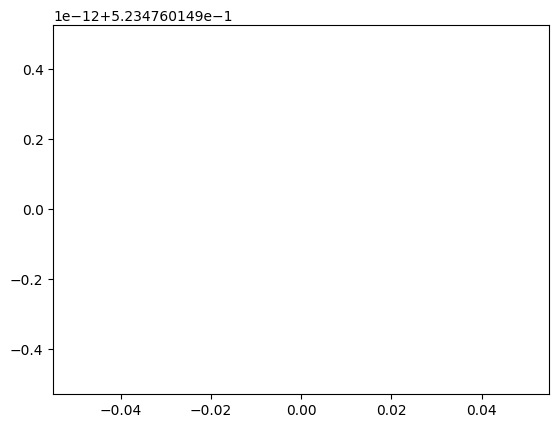

In [41]:
for i in range(len(results)):
    print(i)
    print(results[i]['proportions'])
    plt.plot(sum(results[i]['proportions']))